# Классификация фильмов по сложности восприятия английского языка

**Задача** 
Разработать ML решение для автоматического определения уровня сложности англоязычных фильмов

**Исходные данные**
Размеченный датасет с названиями фильмов, субтитрами и меткой уровня сложности языка ( A1/A2/B1/B2/C1/C2)

**Ход исследования**<br/>
1️⃣ Открыть и загрузить исходные данные по ссылке: https://disk.yandex.ru/d/rQHuC6p6Ztf9Uw. Для обработки файла с субтитрами (формат srt) лучше использовать специализированную библиотеку pysrt https://github.com/byroot/pysrt. <br/>
2️⃣ Провести EDA;<br/>
3️⃣ Попробовать расширить датасет, получив информацию из открытых источников;<br/>
4️⃣ Изучить способы решения подобных задач (примеры: библиотеки по работе с NLP, лемматизация, стемминг и т.д.). Ознакомиться с необходимыми библиотеками и подходами для обработки текстов.<br/>
5️⃣ Подготовить данные для обучения модели, выбрать метрику<br/>
6️⃣ Собрать baseline модель, оценить качество вашего решения и попытаться улучшить его.<br/>

О чем стоит подумать перед началом работы?
- датасет не очень большой, около 200 фильмов. Категорий много. Возможно нужно как-то расширить датасет. В Интернете есть фильмы с метками уровня сложности языка. Если каждый участник Мастерской найдет 10-20 дополнительных фильмов и после все объединят данные – получится уже хороший итоговый датасет, который можно использовать в работе!
- у некоторых фильмов указаны несколько меток, например А2/А2+. Нужно решить как быть с ними.

**Признаки**


**Целевой признак**
- Level — уровень владения английским языком

**Уровни владения английским языком**

В ноябре 2001 года резолюция Совета ЕС рекомендовала Общеевропейскую Шкалу уровней владения иностранным языком (CEFR – Common European Framework of Reference) для создания национальных систем оценки уровня языка.

В CEFR всего шесть уровней:

- `А1` и `А2` – элементарное владение

- `B1` и `B2` – самостоятельное владение

- `С1` и `С2` – свободное владение.

`A1` (Beginner / Уровень выживания) : Вы понимаете и можете говорить, используя знакомые выражения и очень простые фразы для решения конкретных задач в ситуациях повседневного общения.

`A2` (Elementary / Предпороговый уровень ): Вы можете рассказывать о себе, своей семье, профессии, предпочтениях, читать и пересказывать несложные тексты.

`B1` (Intermediate / Пороговый уровень): Вы знаете, как выразить собственное мнение, вести личную беседу и деловую переписку средней сложности, читать адаптированную литературу.

`B2` (Upper intermediate / Пороговый продвинутый уровень): Вы владеете разговорным языком в различных ситуациях, от бытовых до профессиональных, можете без подготовки общаться с  носителем языка.

 `C1` (Advanced / Уровень профессионального владения) : Вы понимаете разнообразные сложные развёрнутые тексты, умеете без подготовки, бегло, не испытывая трудности в подборе слов выражать свои мысли. Ваша речь отличается разнообразием языковых средств и точностью их употребления.

 `C2` (Proficient / Уровень владения в совершенстве): Вы свободно понимаете любую устную и письменную информацию, умеете бегло и чётко излагать свои мысли даже по сложным проблемам, передавая при этом тончайшие оттенки значения.
 
**Полезные ссылки:**
 
- https://www.efset.org/ru/cefr/ - Об уровнях cложности CEFR
 
- https://www.oxfordlearnersdictionaries.com/ - Оксфордский словарь для продвинутых учащихся
 
- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction - Извлечение текстовых признаков

- https://www.kaggle.com/code/neerajmohan/nlp-text-classification-using-tf-idf-features - NLP — классификация текста с использованием функций TF-IDF

- https://habr.com/ru/company/Voximplant/blog/446738/ - Основы Natural Language Processing для текста
- https://docs.lokalise.com/en/articles/5365539-subrip-srt - SubRip (.srt) - О формате SRT

## Подготовка данных

Запрос сформирован тем, что просмотр фильмов на оригинальном языке это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.ч. студент понимал 50 - 70 % диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат от преподавателя.

### Изучение данных

In [1]:

#блок загрузки бибилиотек
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pysrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error

from catboost import CatBoostClassifier, Pool

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import textstat

RANDOM_STATE = 12345
pd.set_option('display.max_columns', None)


In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vadimprimakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vadimprimakov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vadimprimakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vadimprimakov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
try:
    labels = pd.read_csv('/Users/vadimprimakov/Documents/Yandex_practicum/data/movies_labels.csv', sep=';')
except:
    labels = pd.read_csv('/Users/vadimprimakov/Documents/Yandex_practicum/data/movies_labels.csv', sep=';')
    
display(labels.head()) 

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [4]:
# Загрузим предварительно сформированные данные о сложности слов согласно Оксфордского словаря
try:
    df_words = pd.read_csv('Oxsford_dikt.csv')
except:
    df_words = pd.read_csv('/Users/vadimprimakov/Documents/Yandex_practicum/English_movies_classification/app/oxford_dikt.csv')


    
display(df_words.head()) 

,diff,word
0,A1,improve
1,A1,potato
2,A1,night
3,A1,large
4,A1,come


In [5]:
# Загрузим предварительно сформированный список идиом
try:
    df_idioms = pd.read_csv('English_level/theidioms_com.csv', sep='#')
except:
    df_idioms = pd.read_csv('/Users/vadimprimakov/Documents/Yandex_practicum/English_movies_classification/app/theidioms_com.csv', sep='#')
    
display(df_idioms.head()) 

,idiom,lem_idiom,meaning,example
0,drop a line,drop a line,send a brief letter.,"If you've got a few minutes to spare, you coul..."
1,win the day,win the day,to be accepted by other people.,"If you fail to win the day during practice, fo..."
2,the corridors of power,the corridor of power,the office of a powerful leader.,When Jim became a clerk to a Supreme Court jus...
3,by all means,by all mean,in every way possible.,"""Do you mind if I go to the party?"" ""By all me..."
4,piss and vinegar,piss and vinegar,to self-reference someone who is in a bad mood...,"During the invasion, the soldiers were full of..."


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      303 non-null    int64 
 1   Movie   303 non-null    object
 2   Level   303 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.2+ KB


In [7]:
# переименование столбцов
labels = labels.rename(columns = {'Movie' : 'movie', 
                          'Level' : 'level'})

In [8]:
# распределение фильмов по уровням сложности
labels['level'].value_counts()

B2            101
B1             55
C1             50
A1             31
A2/A2+         26
C2             21
B1, B2          8
A2              6
A2/A2+, B1      5
Name: level, dtype: int64

In [9]:
# для упрощения градаций преобразуем уровни сложности до минимального
labels.loc[labels.level == 'A2/A2+', 'level'] = 'A2'
labels.loc[labels.level == 'B1, B2', 'level'] = 'B1'
labels.loc[labels.level == 'A2/A2+, B1', 'level'] = 'A2'

In [10]:
# распределение фильмов по уровням сложности
labels['level'].value_counts()

B2    101
B1     63
C1     50
A2     37
A1     31
C2     21
Name: level, dtype: int64

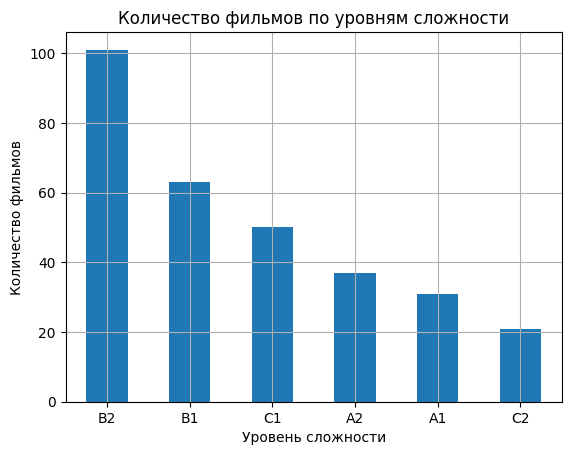

In [11]:
# график количества фильмов в датасете по уровням сложности
labels['level'].value_counts().plot(
    kind='bar', title='Количество фильмов по уровням сложности', grid=True,
    xlabel='Уровень сложности', ylabel='Количество фильмов', rot=0
);

In [12]:
# папка с файлами субтитров
srt_path = r'/Users/vadimprimakov/Documents/Yandex_practicum/data/English_scores/Subtitles_all/subtitles_all'

In [13]:
# получим список файлов с субтитрами
srt_files = os.listdir(srt_path)

# первые 5 файлов
srt_files[:5]

['extr.-Ep-21.srt',
 'Dredd(2012).srt',
 'Crown, The S01E01 - Wolferton Splash.en.srt',
 'Seven.Worlds.One.Planet.S01E06.2160p.BluRay.Remux.eng.srt',
 'The Walking Dead-S01E03-Tell It To The Frogs.English.srt']

In [14]:
# функция сопоставления названия фильма и имени файла субтитров
def fill_file_path(movie):
    """
    функция по названию фильма ищет соответствующее имя файла
    и возвращает его, иначе, возвращает пустую строку
    """
    file_name = ''
    # ищем соответсвующее имя файла в списке
    for i in range(len(srt_files)):
        file = srt_files[i]
        # если есть совпадение
        if file.find(movie) >= 0:
            file_path = os.path.join(srt_path, srt_files[i])
    return file_path

In [15]:
# функция сопоставления названия фильма и имени файла субтитров
def fill_file_name(movie):
    """
    функция по названию фильма ищет соответствующее имя файла
    и возвращает его, иначе, возвращает пустую строку
    """
    file_name = ''
    # ищем соответсвующее имя файла в списке
    for i in range(len(srt_files)):
        file = srt_files[i]
        # если есть совпадение
        if file.find(movie) >= 0:
            file_name = srt_files[i]
    return file_name

In [16]:
# проверим работу функции
fill_file_name('Suits.S03E10.HDTV.x264-mSD')

'Suits.S03E10.HDTV.x264-mSD.srt'

In [17]:
# проверим работу функции
fill_file_path('Suits.S03E10.HDTV.x264-mSD')

'/Users/vadimprimakov/Documents/Yandex_practicum/data/English_scores/Subtitles_all/subtitles_all/Suits.S03E10.HDTV.x264-mSD.srt'

In [18]:
# копируем названия фильмов в новую колонку
labels['file'] = labels['movie']

# применяем функцию для заполнения
labels['file_path'] = labels['movie'].apply(fill_file_path)
labels['file_name'] = labels['movie'].apply(fill_file_name)
# результат заполнения
labels.head()

,id,movie,level,file,file_path,file_name
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016),/Users/vadimprimakov/Documents/Yandex_practicu...,10_Cloverfield_lane(2016).srt
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999),/Users/vadimprimakov/Documents/Yandex_practicu...,10_things_I_hate_about_you(1999).srt
2,2,A_knights_tale(2001),B2,A_knights_tale(2001),/Users/vadimprimakov/Documents/Yandex_practicu...,A_knights_tale(2001).srt
3,3,A_star_is_born(2018),B2,A_star_is_born(2018),/Users/vadimprimakov/Documents/Yandex_practicu...,A_star_is_born(2018).srt
4,4,Aladdin(1992),A2,Aladdin(1992),/Users/vadimprimakov/Documents/Yandex_practicu...,Aladdin(1992).srt


In [19]:
# проверим наличие дублей
labels[labels['file'] == '']

,id,movie,level,file,file_path,file_name


In [20]:
# проверим наличие дублей
labels[labels.file.duplicated(keep=False)].sort_values('file')

,id,movie,level,file,file_path,file_name
43,43,Inside_out(2015),B1,Inside_out(2015),/Users/vadimprimakov/Documents/Yandex_practicu...,Inside_out(2015).srt
44,44,Inside_out(2015),B1,Inside_out(2015),/Users/vadimprimakov/Documents/Yandex_practicu...,Inside_out(2015).srt
38,38,Powder(1995),B1,Powder(1995),/Users/vadimprimakov/Documents/Yandex_practicu...,Powder(1995).srt
68,68,Powder(1995),B1,Powder(1995),/Users/vadimprimakov/Documents/Yandex_practicu...,Powder(1995).srt
75,75,The_blind_side(2009),B2,The_blind_side(2009),/Users/vadimprimakov/Documents/Yandex_practicu...,The_blind_side(2009).srt
84,84,The_blind_side(2009),B1,The_blind_side(2009),/Users/vadimprimakov/Documents/Yandex_practicu...,The_blind_side(2009).srt
83,83,The_terminal(2004),B1,The_terminal(2004),/Users/vadimprimakov/Documents/Yandex_practicu...,The_terminal(2004).srt
99,99,The_terminal(2004),A2,The_terminal(2004),/Users/vadimprimakov/Documents/Yandex_practicu...,The_terminal(2004).srt


In [21]:
# проверим наличие дублей
labels.drop_duplicates()

,id,movie,level,file,file_path,file_name
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016),/Users/vadimprimakov/Documents/Yandex_practicu...,10_Cloverfield_lane(2016).srt
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999),/Users/vadimprimakov/Documents/Yandex_practicu...,10_things_I_hate_about_you(1999).srt
2,2,A_knights_tale(2001),B2,A_knights_tale(2001),/Users/vadimprimakov/Documents/Yandex_practicu...,A_knights_tale(2001).srt
3,3,A_star_is_born(2018),B2,A_star_is_born(2018),/Users/vadimprimakov/Documents/Yandex_practicu...,A_star_is_born(2018).srt
4,4,Aladdin(1992),A2,Aladdin(1992),/Users/vadimprimakov/Documents/Yandex_practicu...,Aladdin(1992).srt
...,...,...,...,...,...,...
298,298,Game Of Thrones S01E06 A Golden Crown,C1,Game Of Thrones S01E06 A Golden Crown,/Users/vadimprimakov/Documents/Yandex_practicu...,Game Of Thrones S01E06 A Golden Crown.srt
299,299,Game Of Thrones S01E07 You Win Or You Die,C1,Game Of Thrones S01E07 You Win Or You Die,/Users/vadimprimakov/Documents/Yandex_practicu...,Game Of Thrones S01E07 You Win Or You Die.srt
300,300,Game Of Thrones S01E08 The Pointy End,C1,Game Of Thrones S01E08 The Pointy End,/Users/vadimprimakov/Documents/Yandex_practicu...,Game Of Thrones S01E08 The Pointy End.srt
301,301,Game Of Thrones S01E09 Baelor,C1,Game Of Thrones S01E09 Baelor,/Users/vadimprimakov/Documents/Yandex_practicu...,Game Of Thrones S01E09 Baelor.srt


In [22]:
# Кодируем целевую переменную
targets = {
           'A1':1, 
           'A2':2,
           'B1':3,
           'B2':4,
           'C1':5,
           'C2':6
           }
labels['target'] = labels['level'].apply(lambda x: targets[x])

## Парсинг субтитров

Файлы _SRT_ это текстовые файлы, которые содержат последовательность записей, каждая запись содержит несколько строк в следующем формате:

1. Порядковый номер фразы.
2. Тайминг, когда фраза начинается и когда заканчивается.
3. Непосредственно текст субтитров может содержать несколько строк. Текст может содержать форматирование в виде тегов _HTML_, либо в виде тегов в фигурных скобках.
4. Пустая строка отделяет одну запись субтитров от другой.

Текст субтитров для каждого фильма находится в отдельном файле. Для более удобной обработки субтитров воспользуемся библиотекой pysrt. Кроме простого прочнения текста субтитров произведём их обработку и извлечение признаков.

1. Очистку от лишних символов и слов:
- признаков начала и конца фраз
- указателей цвета шрифта и фона
- заголовков с именами говорящих

2. Обработку текста:
- приведение всего текста к нижнему регистру
- лемматезацию текста
- удаление стоп-слов

3. Извлечение признаков:
- текстовые: текст, лемматезированный текст, морфологические формы слов.
- признаки на основе сложности слов,
- признаки на основе библиотеки textstat: индекс удобочитаемости, уровень оценки Флеша-Кинкейда, индекс Коулмана-Лиау и тд.
- темп речи, доля идиом, морфологическая сложность, среднее количество уникальных слов во фразе и т.д.

In [23]:
wnl = WordNetLemmatizer()

In [24]:
def sub_processing(filename):
    """ Принимаем имя файла субтитров
        Возвращаем список параметров расчитаных на основе обработки файла
    """
    # читаем файл субтитров
    try:
        subs = pysrt.open('/Users/vadimprimakov/Documents/Yandex_practicum/data/English_scores/Subtitles_all/subtitles_all/' + filename)
    except:
        subs = pysrt.open('/Users/vadimprimakov/Documents/Yandex_practicum/data/English_scores/Subtitles_all/subtitles_all/' + filename, encoding='latin-1')
        
    # Время начала фольма
    film_start = subs[0].start.hours*3600 + subs[0].start.minutes*60 + subs[0].start.seconds
    # Время окончания фильма
    if subs[-1].index - subs[-2].index < 2:
        film_end = subs[-1].end.hours*3600 + subs[-1].end.minutes*60 + subs[-1].end.seconds
    else:
        film_end = subs[-2].end.hours*3600 + subs[-2].end.minutes*60 + subs[-2].end.seconds\
    # Продолжительность фильма
    film_start, film_end = min(film_start, film_end), max(film_start, film_end)
    film_lenght = film_end - film_start
        
    # Очистка текста
    # text = re.sub('<i>|</i>', '', subs.text)
    text = re.sub('\<.*?\>', '', subs.text)      # удаляем то что в скобках <>
    text = re.sub('\n', ' ', text)               # удаляем разделители строк    
    # text = re.sub('<font.*?font>', '', text)
    text = re.sub('\(.*?\)', '', text)           # удаляем то что в скобках ()    
    text = re.sub('\[.*?\]', '', text)           # удаляем то что в скобках []
    text = re.sub('[A-Z]+?:', '', text)          # удаляем слова написанные заглавными буквами с двоеточием(это имена тех кто говорит)
    text = re.sub('\.+?:', '\.', text)           # Заменяем троеточия на одну точку
    text = text.lower()
    text = re.sub('[^a-z\.\!\?]', ' ', text)     # удаляем всё что не буквы и не .?!
    text = re.sub(' +', ' ', text)               # удаляем " +"
    # text = re.sub(r'\n ', '', text)
     
    # Количество предложений
    num_sentence = len(re.split('[\.\?\!]', text))
    
    # морфологический разбор
    morphs = [_[1] for _ in nltk.pos_tag(re.sub('\n', ' ', text).lower().split(' '))]
    # Герундий
    gerund = morphs.count('VBG')
    
    text_no_preproc = text
    text = re.sub('[^a-z]', ' ', text)     # удаляем всё что не буквы
    
    # ищем идиомы
    num_idioms = 0
    for idiom in df_idioms['lem_idiom']:
        match = re.finditer(fr'{idiom}', text)
        num_idioms += len([_ for _ in match])
    
    # Количество символов
    text_len = len(text)
    # Букв в секунду
    sumb_persecond = text_len / film_lenght
    
    # # Избавимся от стоп-слов
    # for stop_word in nltk_stopwords.words('english'):
    #     text = re.sub(f' {stop_word} ', ' ', text)
        
    # удалим однобуквенные слова
    text = re.sub(' [a-z] ', ' ', text)
    text = re.sub(' [a-z] ', ' ', text)
    text = re.sub(' [a-z] ', ' ', text)
    
    text_no_lem = text
    
     # Список уникальных слов
    words = text.split(' ')
    words_unique = []
    for word in words:
        if word not in words_unique:
            words_unique.append(word)
    
    sumb_perword = (text_len - len(words)) / len(words)
        
    # Расчитаем количество слов разной сложности в фильме 
    difficulty = {'A1':0,
                  'A2':0,
                  'B1':0,
                  'B2':0,
                  'C1':0,
                  'C2':0
                 }
    
    for word in words_unique:
        match = df_words[df_words['word'] == word]['diff'].values
        if len(match) > 0:
            for dif in match:
                difficulty[dif] += 1
       
    # Лемматизация
    text = ' '.join([wnl.lemmatize(word, wordnet.VERB) for word in text.split(' ')])
    
    # Посчитаем продолжительность всех фраз
    phrases_lenght = 0
    for sub in subs:
         # Время начала фразы
        phrase_start = sub.start.hours*3600 + sub.start.minutes*60 + sub.start.seconds
        # Время окончания фразы
        phrase_end = sub.end.hours*3600 + sub.end.minutes*60 + sub.end.seconds
        # Продолжительность фразы
        phrases_lenght += max(0, phrase_end - phrase_start)
    
    sumb_persecond_frases = text_len / phrases_lenght
    
    # Возвращаем результаты
    return [film_lenght,
            text_len, 
            len(text),
            sumb_persecond, 
            phrases_lenght,
            sumb_persecond_frases,
            sumb_perword,
            max(num_sentence, len(subs)),
            len(words) / max(num_sentence, len(subs)),
            difficulty['A1']/len(words_unique),
            difficulty['A2']/len(words_unique),
            difficulty['B1']/len(words_unique),
            difficulty['B2']/len(words_unique),
            difficulty['C1']/len(words_unique),
            difficulty['C2']/len(words_unique),
            len(subs),
            len(words_unique) / len(subs),
            len(words),
            len(words_unique),
            len(words_unique) / film_lenght,
            len(words_unique) / len(words),
            textstat.flesch_reading_ease(text_no_preproc),
            textstat.flesch_kincaid_grade(text_no_preproc),
            textstat.smog_index(text_no_preproc),
            textstat.coleman_liau_index(text_no_preproc),
            textstat.automated_readability_index(text_no_preproc),
            textstat.dale_chall_readability_score(text_no_preproc),
            textstat.difficult_words(text_no_preproc),
            textstat.linsear_write_formula(text_no_preproc),
            textstat.gunning_fog(text_no_preproc),
            textstat.text_standard(text_no_preproc),
            textstat.fernandez_huerta(text_no_preproc),
            textstat.szigriszt_pazos(text_no_preproc),
            textstat.gutierrez_polini(text_no_preproc),
            textstat.crawford(text_no_preproc),
            textstat.gulpease_index(text_no_preproc),
            textstat.osman(text_no_preproc),
            num_idioms,
            gerund,
            gerund / num_sentence, 
            text,
            text_no_lem,
            ' '.join(morphs)
           ]

In [25]:
%%time
new_columns = ['film_lenght', 
               'text_len', 
               'lematise_text_len', 
               'sumb_persecond',
               'phrases_lenght',
               'sumb_persecond_frases',
               'sumb_perword',
               'num_sentence',
               'word_persentence',
               'A1',
               'A2',
               'B1',
               'B2',
               'C1',
               'C2',
               'phrases_count',
               'words_unique_perphrase', 
               'words_count',
               'words_unique_count',
               'words_unique_persecond',
               'lexical_diversity',
               'flesch_reading_ease',
               'flesch_kincaid_grade',
               'smog_index',
               'coleman_liau_index',
               'automated_readability_index',
               'dale_chall_readability_score',
               'difficult_words',
               'linsear_write_formula',
               'gunning_fog',
               'text_standard',
               'fernandez_huerta',
               'szigriszt_pazos',
               'gutierrez_polini',
               'crawford',
               'gulpease_index',
               'osman',
               'num_idioms',
                'gerund',
                'gerund_persentence', 
               'text',
               'text_no_lem',
               'morphs'
              ]

labels.loc[~labels['file_name'].isna(), new_columns] = [_ for _ in labels.loc[~labels['file_name'].isna(), 'file_name'].apply(sub_processing)]
labels.head()

CPU times: user 9min 8s, sys: 7.74 s, total: 9min 15s
Wall time: 10min 2s


,id,movie,level,file,file_path,file_name,target,film_lenght,text_len,lematise_text_len,sumb_persecond,phrases_lenght,sumb_persecond_frases,sumb_perword,num_sentence,word_persentence,A1,A2,B1,B2,C1,C2,phrases_count,words_unique_perphrase,words_count,words_unique_count,words_unique_persecond,lexical_diversity,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,text_standard,fernandez_huerta,szigriszt_pazos,gutierrez_polini,crawford,gulpease_index,osman,num_idioms,gerund,gerund_persentence,text,text_no_lem,morphs
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016),/Users/vadimprimakov/Documents/Yandex_practicu...,10_Cloverfield_lane(2016).srt,3,5788.0,25102.0,23226.0,4.336904,2083.0,12.050888,3.607562,1064.0,5.120301,0.234250,0.111801,0.090506,0.070098,0.025732,0.011535,1064.0,1.059211,5448.0,1127.0,0.194713,0.206865,97.91,1.4,6.1,2.33,1.3,5.79,350.0,3.500000,3.90,3rd and 4th grade,127.39,124.09,55.41,-0.4,89.5,96.22,26.0,101.0,0.101000,fix sync by bozxphd enjoy the flick ben on mi...,fixed synced by bozxphd enjoy the flick ben o...,VBN VBN IN NN VBP DT NN NN IN JJ NN VB NN NN N...
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999),/Users/vadimprimakov/Documents/Yandex_practicu...,10_things_I_hate_about_you(1999).srt,3,5724.0,43011.0,39852.0,7.514151,2897.0,14.846738,3.540857,1660.0,5.706024,0.206431,0.106109,0.101608,0.093891,0.040514,0.014148,1188.0,1.308923,9472.0,1555.0,0.271663,0.164168,97.20,1.7,6.1,2.05,0.8,5.56,535.0,2.785714,4.02,1st and 2nd grade,126.68,124.17,56.59,-0.2,87.7,99.60,50.0,152.0,0.091566,hey ll be right with you so cameron here yo...,hey ll be right with you so cameron here yo...,NN NN VBP VB JJ IN NNS RB RB RB PRP VBP CD NNS...
2,2,A_knights_tale(2001),B2,A_knights_tale(2001),/Users/vadimprimakov/Documents/Yandex_practicu...,A_knights_tale(2001).srt,4,7914.0,38778.0,36589.0,4.899924,3029.0,12.802245,3.261787,2201.0,4.134030,0.204178,0.120620,0.091644,0.081536,0.043801,0.018194,1216.0,1.220395,9099.0,1484.0,0.187516,0.163095,98.82,1.1,5.9,1.68,1.2,5.45,423.0,2.125000,3.24,1st and 2nd grade,128.31,125.06,55.83,-0.8,94.3,97.14,36.0,61.0,0.027715,resync xenzai retail should we help him he du...,resync xenzai retail should we help him he du...,NN NNS JJ MD PRP VB VB PRP VB JJ IN DT NNS IN ...
3,3,A_star_is_born(2018),B2,A_star_is_born(2018),/Users/vadimprimakov/Documents/Yandex_practicu...,A_star_is_born(2018).srt,4,8117.0,64895.0,59724.0,7.994949,5000.0,12.979000,3.382132,2559.0,5.787026,0.247415,0.139586,0.085672,0.091581,0.025849,0.016987,2152.0,0.629182,14809.0,1354.0,0.166810,0.091431,105.35,0.6,5.6,0.89,-0.1,1.10,330.0,7.000000,3.62,0th and 1st grade,132.37,127.04,58.48,-0.4,88.6,105.28,97.0,260.0,0.101602,sync and correct by mrcjnthn get to it black...,synced and corrected by mrcjnthn get to it b...,NN VBD CC VBN IN NN NN TO VB JJ NNS JJ JJ PRP ...
4,4,Aladdin(1992),A2,Aladdin(1992),/Users/vadimprimakov/Documents/Yandex_practicu...,Aladdin(1992).srt,2,5313.0,41162.0,38633.0,7.747412,3978.0,10.347411,3.488768,1669.0,5.494308,0.196286,0.129973,0.086870,0.086870,0.037135,0.020557,1470.0,1.025850,9170.0,1508.0,0.283832,0.164449,96.99,1.8,6.0,2.17,1.1,5.46,422.0,58.000000,3.98,1st and 2nd grade,126.48,123.97,56.36,-0.1,86.5,98.87,56.0,86.0,0.051528,oh come from land from faraway place where the...,oh come from land from faraway place where the...,UH JJ VBP IN DT NN IN DT NN NN WRB DT NN NNS V...


In [26]:
labels['avg_dificulty'] = labels[['A1','A2','B1','B2','C1','C2']].apply(lambda x: np.mean([x['A1'], x['A2']*1.5, x['B1']*5, x['B2']*50, x['C1']*500, x['C2']*750]) ,axis=1)
labels['idioms_persentence'] = labels['num_idioms'] / labels['num_sentence'] 

**Вывод:**

Файлы субтитров обработаны. Извлечены признаки из текста субтитров.

На первом этапе была произведена загрузка исходного датасета и сформирован итоговый датасет на основе данных из файлов субтитров. Извлечены признаки необходимые для построения модели машинного обучения.

## Анализ данных

В данном разделе проанализируем полученные признаки, и попробуем понять чем отличаются фильмы разной сложности.

- Сформируем сводную таблицу по уровням фильмов со средними значениями всех параметров.
- Построим парные графики с разделением по уровню фильмов.
- Построим корреляционную матрицу с целью выявления корреляционных зависимостей.

In [27]:
pivot_table = labels[labels['level'].isin(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])].groupby('level').mean()
pivot_table

/var/folders/kt/mlhg2qys2t7gv5_hsly670l40000gn/T/ipykernel_4859/2433772433.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivot_table = labels[labels['level'].isin(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])].groupby('level').mean()


,id,target,film_lenght,text_len,lematise_text_len,sumb_persecond,phrases_lenght,sumb_persecond_frases,sumb_perword,num_sentence,word_persentence,A1,A2,B1,B2,C1,C2,phrases_count,words_unique_perphrase,words_count,words_unique_count,words_unique_persecond,lexical_diversity,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,fernandez_huerta,szigriszt_pazos,gutierrez_polini,crawford,gulpease_index,osman,num_idioms,gerund,gerund_persentence,avg_dificulty,idioms_persentence
level,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1,267.032258,1.0,1550.612903,7421.354839,6961.935484,4.995195,964.225806,8.978715,3.322386,389.838710,4.442022,0.402591,0.129005,0.078762,0.050321,0.018621,0.012064,279.483871,1.372529,1717.290323,379.258065,0.255157,0.221612,97.341290,1.293548,5.780645,1.592581,0.896774,5.282903,64.032258,3.348121,3.154194,127.229355,124.338387,56.213871,-0.687097,94.725806,98.506129,9.032258,18.645161,0.049557,3.644083,0.023127
A2,65.810811,2.0,5778.729730,39441.081081,36821.810811,6.778962,3139.081081,12.562239,3.423055,1733.864865,5.247486,0.233332,0.131793,0.086036,0.085436,0.032576,0.014680,1314.135135,1.051881,8899.810811,1291.297297,0.231011,0.155124,97.978649,1.510811,5.945946,1.745946,0.832432,5.302162,373.243243,8.591325,3.711081,127.332703,124.934595,56.628378,-0.359459,89.486486,99.879730,56.594595,114.486486,0.068950,5.405221,0.034643
B1,78.873016,3.0,6058.920635,41393.190476,38635.095238,6.728569,3170.555556,13.044481,3.508736,1814.539683,5.481552,0.228575,0.129203,0.088761,0.089120,0.031068,0.014463,1291.349206,1.249211,9290.174603,1390.428571,0.234427,0.169268,95.700000,1.903175,6.307937,2.430159,1.441270,5.450159,428.158730,5.616129,4.018413,125.614603,123.080317,55.559206,-0.144444,87.346032,96.744444,60.650794,121.333333,0.074228,5.283868,0.034432
B2,136.683168,4.0,4246.287129,41158.653465,38231.544554,11.144944,2719.148515,15.778276,3.580159,1552.623762,6.188757,0.233495,0.132531,0.092261,0.094206,0.035224,0.014797,1240.000000,1.091717,9018.534653,1312.237624,0.358519,0.149713,95.721287,2.073267,6.392079,2.270792,1.259406,5.273168,417.237624,4.130769,4.236634,125.421188,122.822574,56.090099,0.057426,85.458416,98.161584,56.198020,153.326733,0.125265,5.718880,0.037555
C1,213.720000,5.0,3254.060000,33925.980000,31492.660000,11.060473,2221.920000,15.320987,3.637504,1134.620000,6.604764,0.237412,0.132318,0.093879,0.092451,0.034784,0.014771,983.700000,1.232830,7299.160000,1171.400000,0.379548,0.164799,95.883400,2.116000,6.288000,2.258400,1.202000,5.354400,345.400000,4.210289,4.279800,125.460400,123.234600,56.169200,0.084000,84.706000,98.361400,45.040000,123.840000,0.124008,5.666414,0.039892
C2,265.714286,6.0,2499.619048,18128.666667,16927.571429,8.177702,1419.142857,12.525006,3.397716,757.857143,5.333435,0.273276,0.127760,0.085688,0.076770,0.028357,0.013168,667.571429,1.374298,4092.809524,833.333333,0.407963,0.218201,98.674286,1.409524,5.723810,1.642857,0.700000,5.622857,195.285714,5.405715,3.673333,127.808571,126.205238,56.890000,-0.419048,89.119048,100.712857,22.714286,58.380952,0.078370,4.797737,0.029289


/var/folders/kt/mlhg2qys2t7gv5_hsly670l40000gn/T/ipykernel_4859/283634366.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(labels[labels['target'] != 0].corr(), square=True, annot=True);


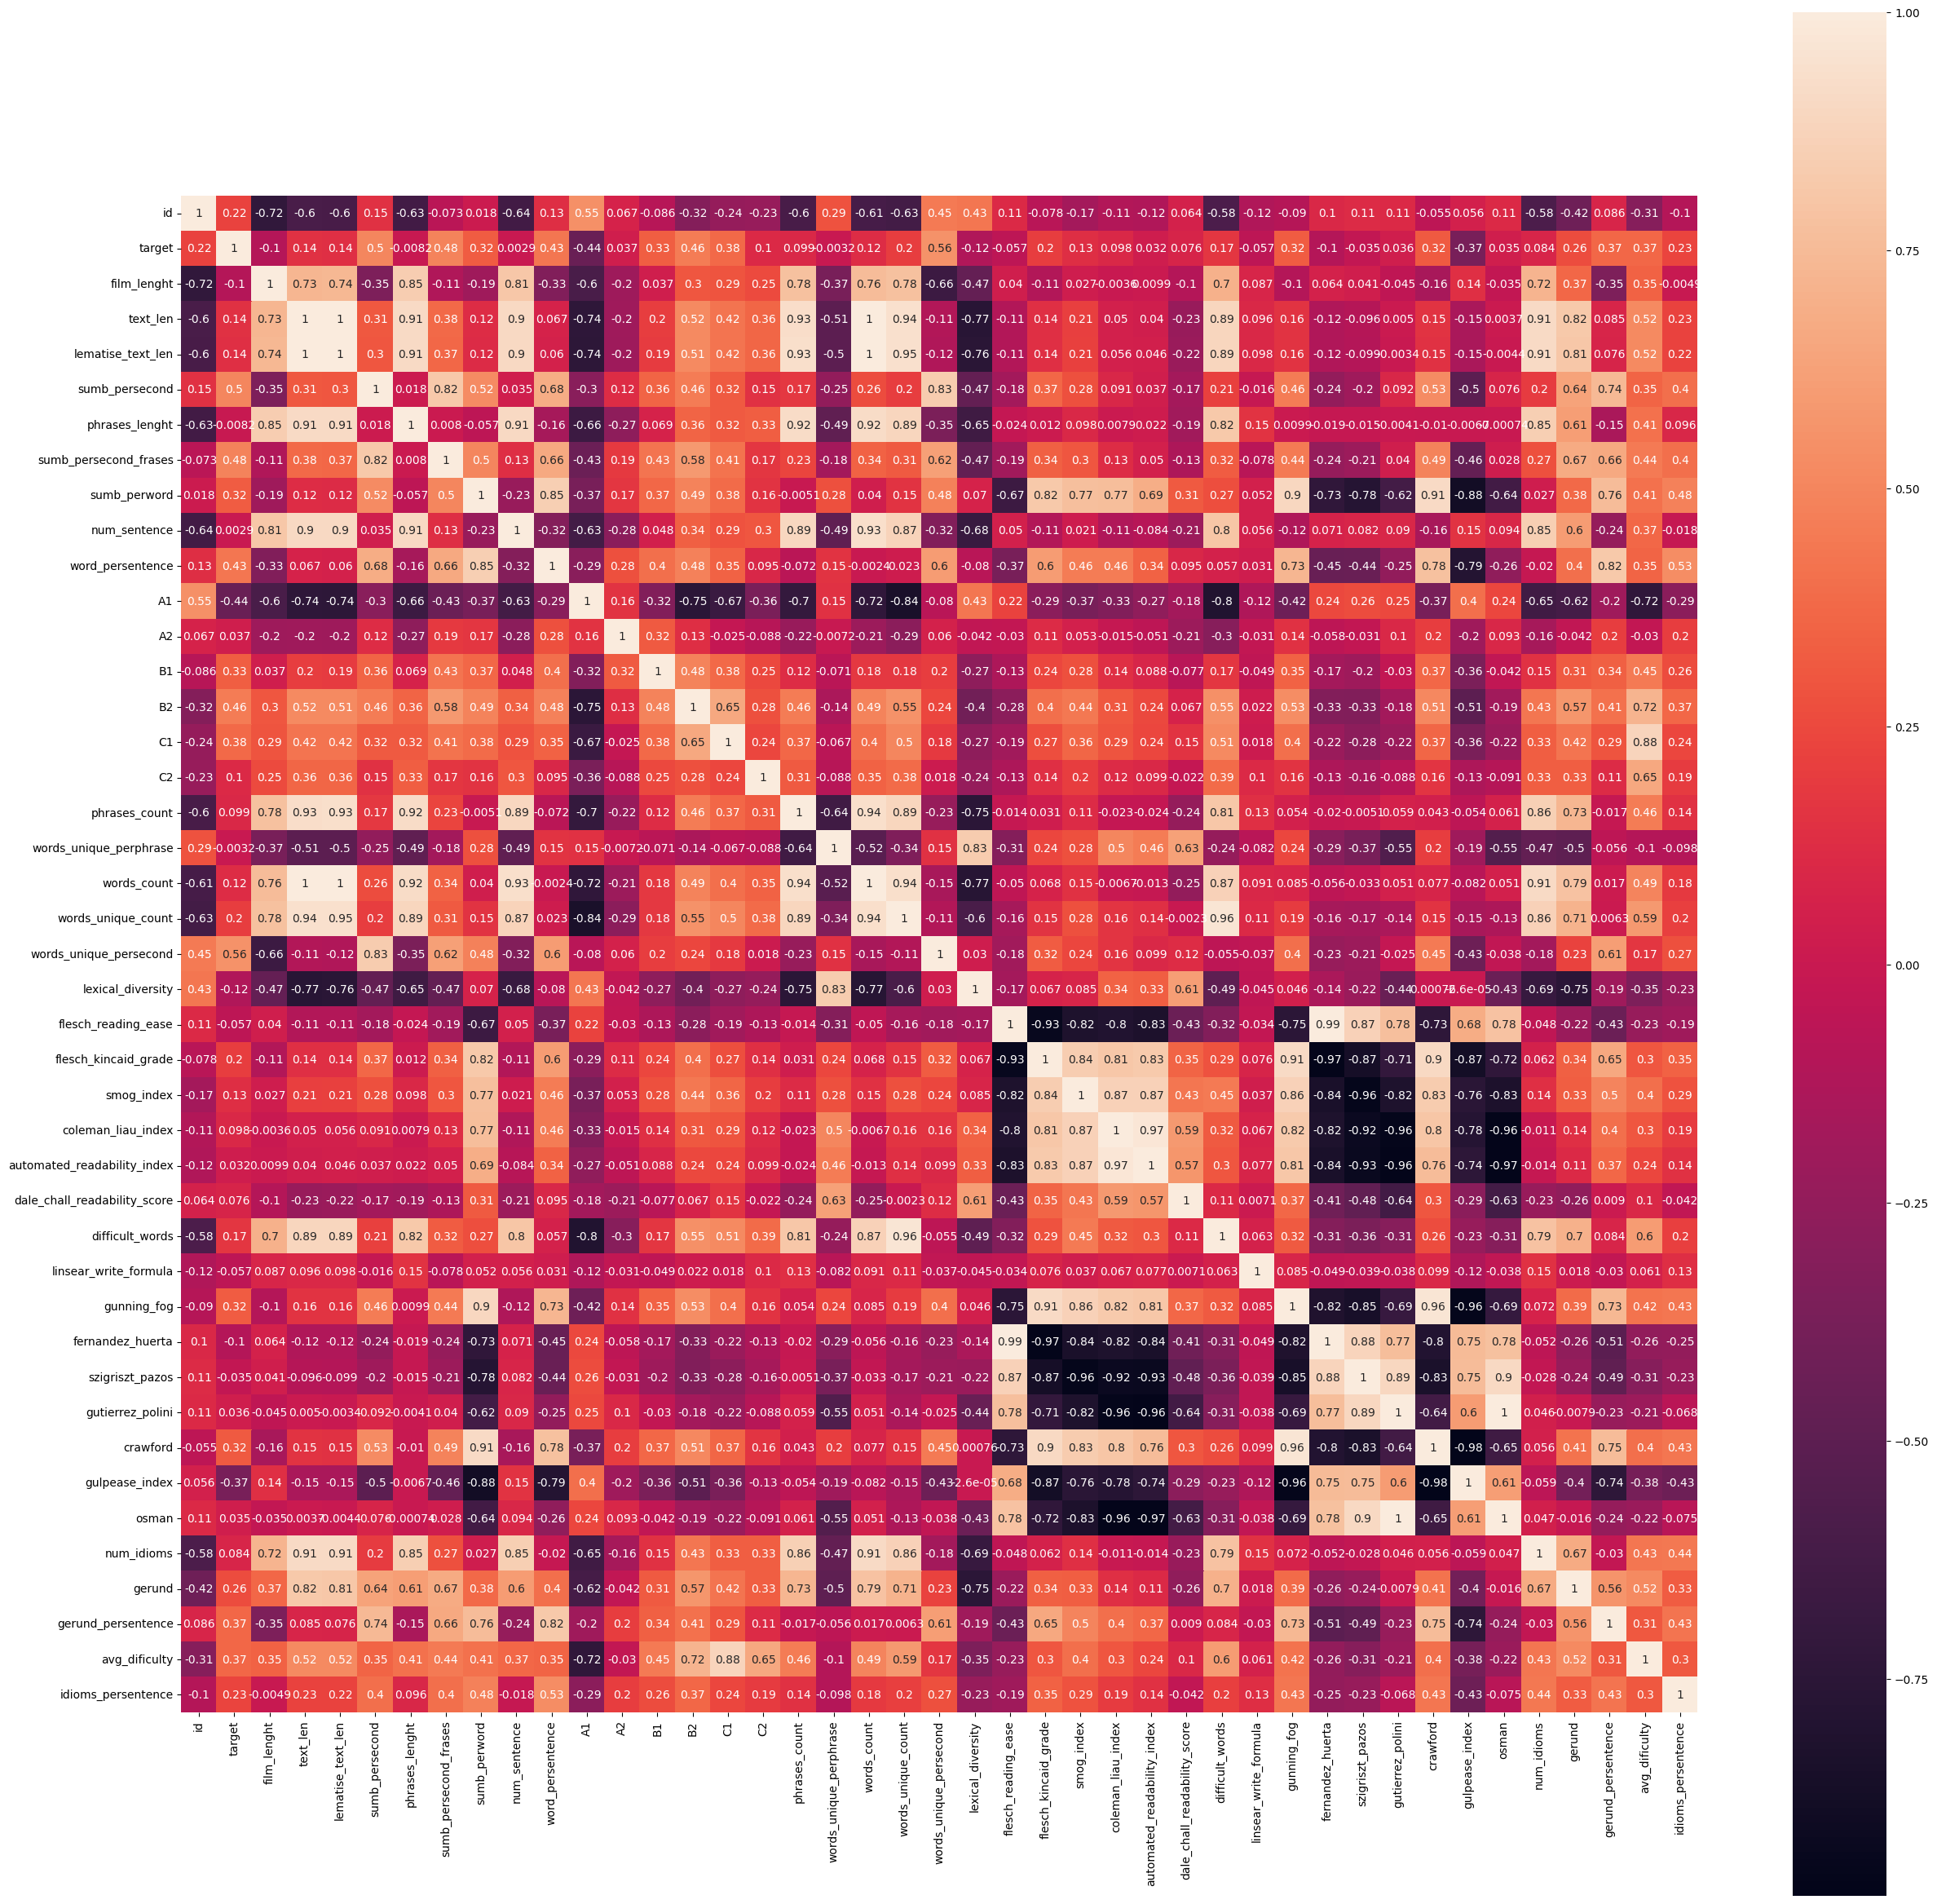

In [28]:
plt.rcParams['figure.figsize']=(30,30)
sns.heatmap(labels[labels['target'] != 0].corr(), square=True, annot=True);

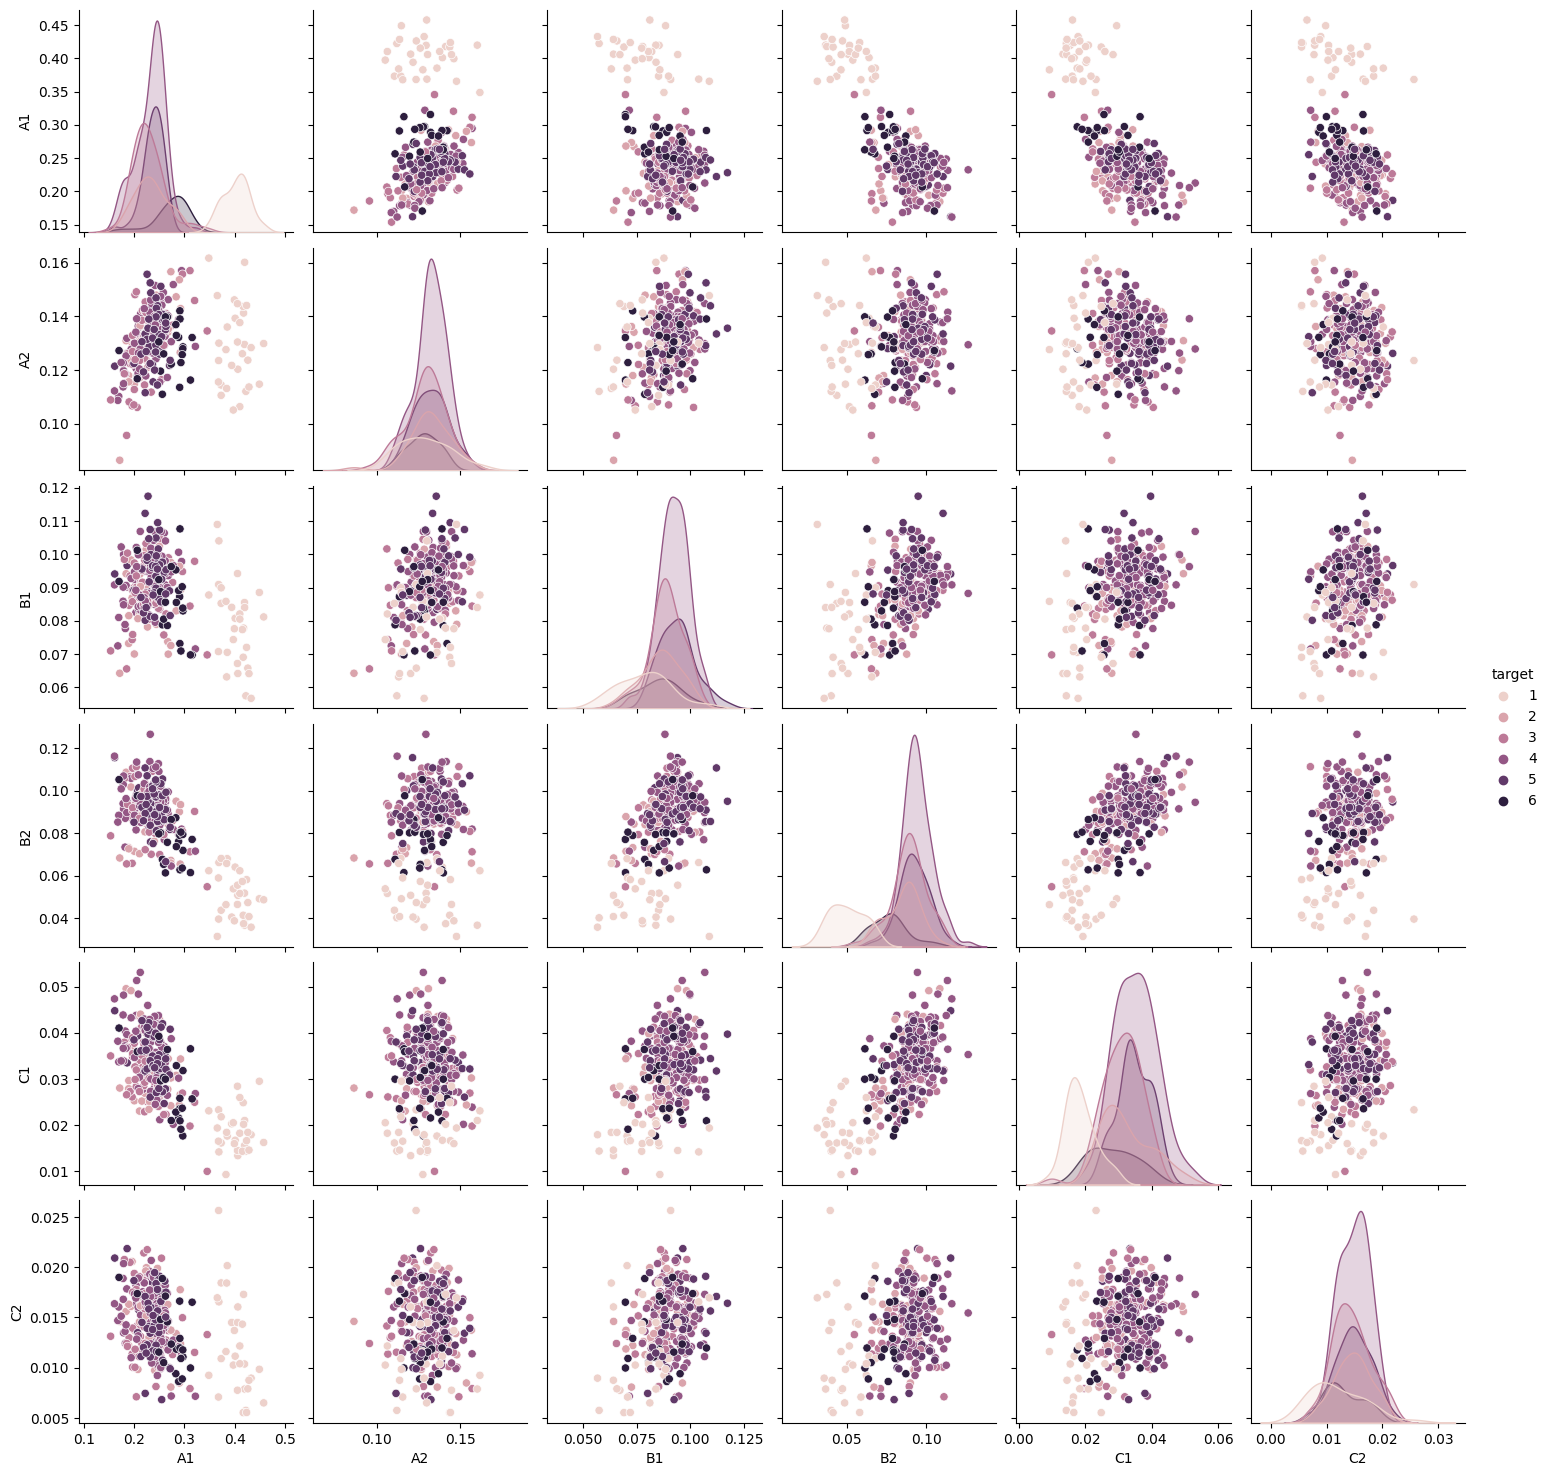

In [29]:
sns.pairplot(data=labels[['A1','A2','B1','B2','C1','C2','target']], hue='target');

**Вывод:**

Исходя из анализа построенной корреляционной матрицы, можно сделать следующие выводы:

- Целевой признак не имеет сильной корреляционной зависимости от какого-либо признака.
- Примерно половина признаков имеют сильные корреляционные зависимости друг с другом
- На построенных парных графиках также невидно возможности чётко разделить объекты по целевому признаку.

Таким образом, на данном этапе невозможно выделить признаки наиболее чётко ввделяющие один класс от другого. Можно лишь избавться от от признаков сильно коррелирующих друг с другом.

## Построение модели машинного обучения

Для решения поставленной задачи были применены разные модели машинного обучения, разные наборы признаков и разные подходы к кодированию текстовой информации. Я не буду приводить здесь все варианты решений, а остановлюсь только на том, который показал наибольшую эффективность:

Модель: CatBoostClassifier
Набор признаков:
- phrases_lenght - средняя длина фразы
- B2 - доля уникальных слов сложности B2
- coleman_liau_index - уровень качества текста по формуле Коулмана-Лиау
- word_persentence - среднее количество слов во фразе
- gulpease_index - индекс текста Gulpease(вообще он для итальянского текста, но подошел и к английскому)
- gerund_persentence - среднее количество герундия во фразе
- words_unique_perphrase - среднее количество уникальных слов во фразе
- words_unique_persecond - среднее количество уникальных слов в секунду
- phrases_count - количество фраз в тексте
- avg_dificulty - средняя сложность слов
- idioms_persentence - среднее количество идиом во фразе

Кодировка текста производилась внутренним алгоритмом модели CatBoostClassifier. А в качестве текста выступали морфологические формы слов.

### Подготовка выборок

Разделим датасет на тренировочную и тестовую выборки.
Обучим модель и подберём гиперпараметры
Протестируем модель

In [30]:
effective_features =[
        'movie',
        'phrases_lenght', 
        'B2', 
        'coleman_liau_index', 
        'word_persentence', 
        'gulpease_index', 
        'gerund_persentence', 
        'words_unique_perphrase', 
        'words_unique_persecond',
        'phrases_count',
        'target',
        'avg_dificulty',
        'idioms_persentence',
]

In [31]:
features = labels[effective_features].set_index('movie').copy()

X = features.drop(columns=['target'])
y = features['target']

In [32]:
X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_tv, y_tv, test_size=0.5, random_state=RANDOM_STATE)
print('Размер тренировочной выборки - {:.0%}'.format(X_train.shape[0]/X.shape[0]))
print('Размер валидационной выборки - {:.0%}'.format(X_valid.shape[0]/X.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(X_test.shape[0]/y.shape[0]))

Размер тренировочной выборки - 80%
Размер валидационной выборки - 10%
Размер тестовой выборки - 10%


In [33]:
# Для модели CatBoostClassifier сформируем пулы
# Тренировочный пул
train_pool = Pool(data=X_train,
                  label=y_train,
                 )
# Валидационный пул
valid_pool = Pool(data=X_valid,
                   label=y_valid,
                  )
# Тестовый пул
test_pool = Pool(data=X_test,
                   label=y_test,
                  )

# Тренировочный + Валидационный пул
learn_pool = Pool(data=pd.concat([X_train, X_valid]),
                  label=pd.concat([y_train, y_valid])
                 )

Так как датасет имеет совсем небольшой размер, модель градиентного бустинга очень легко переобучается. Поэтому было решено в качестве индикатора переобучения использовать валидационную выборку.

In [34]:
def fit_model(train_pool, valid_pool, **kwargs):
    """ Принимаем тренировочный и тестовый пул, а также параметры модели.
        Возвращаем обученную модель
    """
    model = CatBoostClassifier(
                               eval_metric='TotalF1',
                               od_type='Iter',
                               od_wait=500,
                               tokenizers=
                                     [{'tokenizer_id': 'Sense',
                                       'separator_type': 'BySense',
                                       'lowercasing': 'True',
                                       'token_types':['Word', 'Number', 'SentenceBreak'],
                                       'sub_tokens_policy':'SeveralTokens'
                                      }],
                                     dictionaries = [{'dictionary_id': 'Word','max_dictionary_size': '1000'}],
                                     feature_calcers = ['BoW:top_tokens_count=1000'],
                               **kwargs
                              )
    return model.fit(train_pool,
                     eval_set=valid_pool,
                     verbose=100,
                     plot=True,
                     use_best_model=True)

In [35]:
%%time
# Обучаем модель
model = fit_model(train_pool,
                  valid_pool,
                  learning_rate=0.1,
                  n_estimators=200,
                  max_depth=10,
                  l2_leaf_reg=1e-08
                )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7014674	test: 0.3840049	best: 0.3840049 (0)	total: 261ms	remaining: 52s
100:	learn: 0.9958806	test: 0.5881609	best: 0.6404762 (20)	total: 14.2s	remaining: 13.9s
199:	learn: 0.9958806	test: 0.6166667	best: 0.6833333 (165)	total: 26.8s	remaining: 0us

bestTest = 0.6833333333
bestIteration = 165

Shrink model to first 166 iterations.
CPU times: user 1min, sys: 744 ms, total: 1min 1s
Wall time: 27 s


In [36]:
preds = model.predict(valid_pool)
accuracy_score(preds, y_valid)

0.6666666666666666

## Тестирование модели

- Протестируем модель на тестовой выборке и сохраним обученную модель для дальнейшего использования в скрипте микросервиса.
- Сравним работу модели с фиктивной моделью.
- Оценим важность признаков

In [37]:
preds = model.predict(test_pool)
accuracy_score(preds, y_test)

0.6774193548387096

In [38]:
%%time
# Обучаем модель
model = fit_model(learn_pool,
                  test_pool,
                  learning_rate=0.1,
                  n_estimators=200,
                  max_depth=10,
                  l2_leaf_reg=1e-08
                 )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6968238	test: 0.4331797	best: 0.4331797 (0)	total: 265ms	remaining: 52.6s
100:	learn: 0.9926143	test: 0.6600248	best: 0.6811461 (89)	total: 14.4s	remaining: 14.2s
199:	learn: 0.9926296	test: 0.6217428	best: 0.6811461 (89)	total: 29.9s	remaining: 0us

bestTest = 0.6811461035
bestIteration = 89

Shrink model to first 90 iterations.
CPU times: user 1min 8s, sys: 807 ms, total: 1min 9s
Wall time: 30 s


In [39]:
# Сохраним обученную модель для дальнейшего использования
model.save_model('catboostclassifier_model.cbm')

**Вывод:** 

Работа модели на тестовой выборке показала точность 0.67. 
Модель для продакшена была обучена на тренировочной + валидационной выборках, а в качестве индикатора переобучения использована тестовая выборка. При этом точность модели была оценена 0.80.

## Фиктивная модель

Для понимания как наша модель работает по отношению к фиктивной модели, которая будет работать по стратегии "most friqued", рассчитаем точность такой модели.

In [40]:
clases = y.value_counts()
clases

4    101
3     63
5     50
2     37
1     31
6     21
Name: target, dtype: int64

In [41]:
clases.max() /  clases.sum()

0.3333333333333333

**Вывод:** Точность фиктивной модели примерно в два раза ниже, чем наша обученная модель.

## Оценка важности признаков

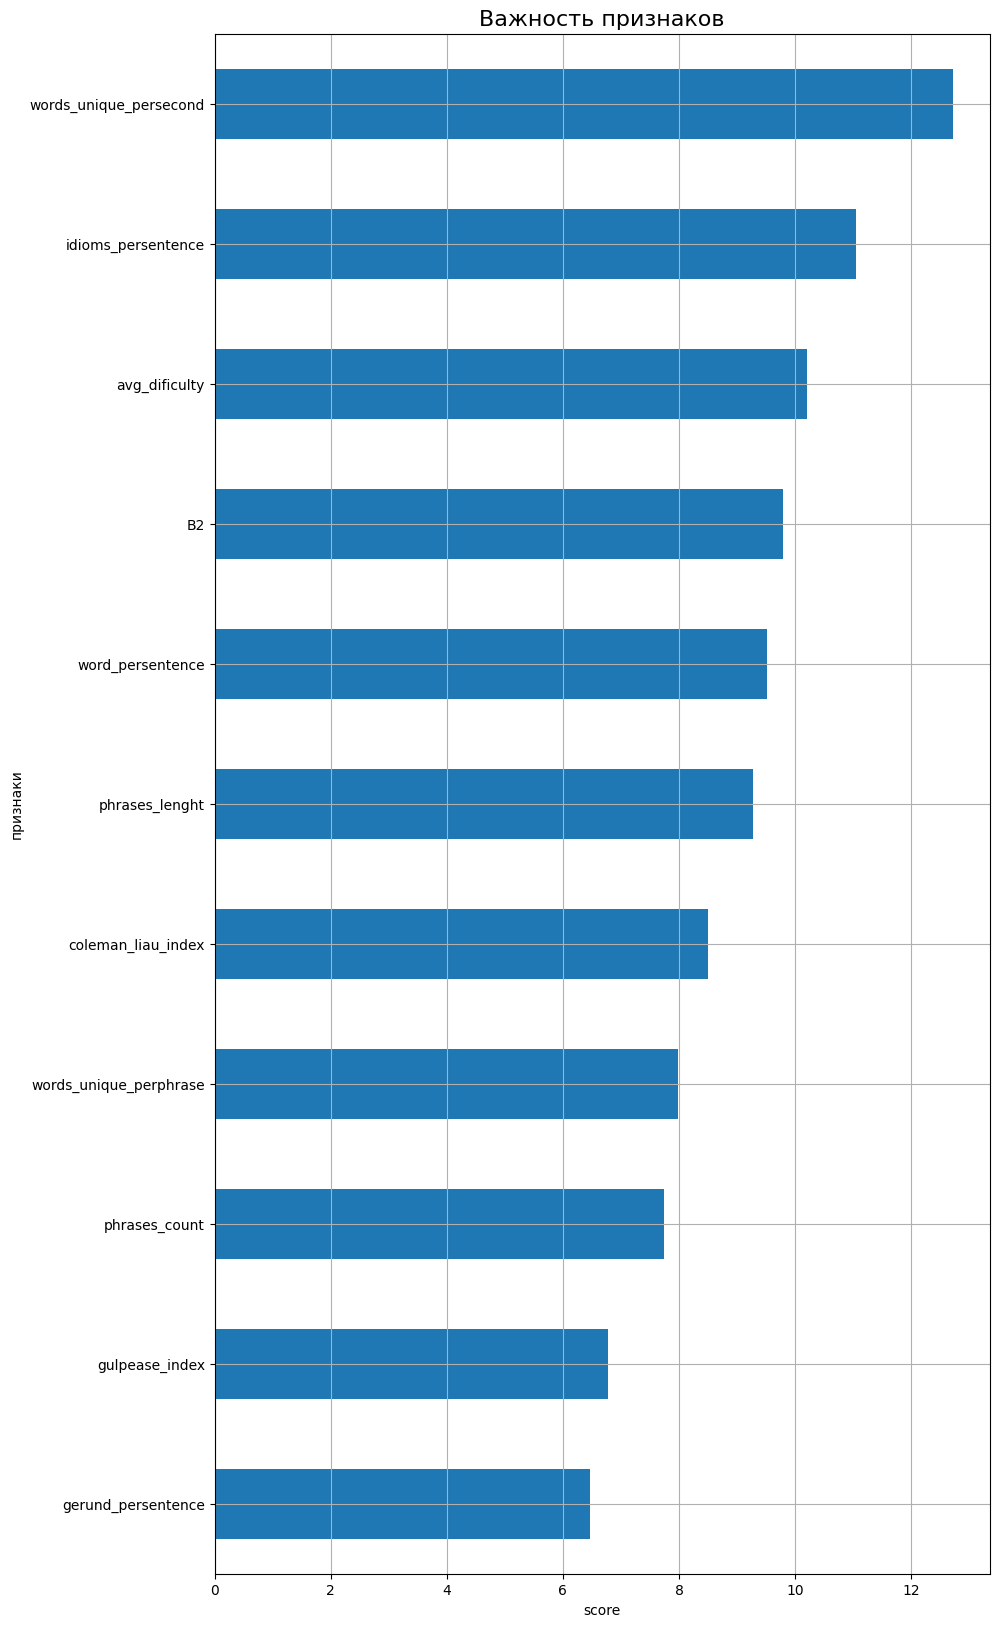

In [42]:
# Выделим признаки
effective_score = pd.DataFrame(data={'score': model.feature_importances_}, 
                            index=X_train.columns).sort_values(by='score')
# Выведем их на экран
ax = effective_score.plot(kind='barh', grid=True, figsize=(10,20), legend=False)
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

**Вывод:** На графике видно, что наибольшую важность имеют признаки:

- words_unique_persecond - среднее количество уникальных слов в секунду
- idioms_persentence - среднее количество идиом во фразе
- avg_dificulty - средняя сложность слов
- B2 - доля уникальных слов уровня B2



Модель обучена и протестирована. Заданного порога качества задано не было, качество в 2 раза больше фиктивной модели - вполне приемлемый результат.

**Вывод**

На этапе подготовки данных была выполнена загрузка и первичный анализ данных, предобработка исходного датасета и формирования признакового пространства из информации находящийся в файлах субтитров. Для этого были использованы возможности библиотек pysrt, nltk и texstat. За рамками данной тетрадки остался процесс парсинга Оксфордского словаря сложности слов и составление словаря идиом. Также, файлы субтитров и сложность фильмов по классификации CEFR были внесены в датасет по результатам поиска в открытых источниках.

На этапе анализа данных были выявлены сильные корреляционные зависимости между большой частью признаков, но небыло выявлено корреляции признаков с целевой переменной. Это делало работу модели не простой задачей.

Для построения модели машинного обучения из большого числа вариантов кодирования, извлечения признаков и типов моделей машинного обучения был выбран наиболее эффективный. На тестовой выборке удалось достичь метрики качества TotalF1 = 0.67. Это в 2 раза лучше чем показывает фиктивная модель.

Факторы мешающие достижению большего качества, на мой взгляд, следующие:

Размер датасета очень небольшой. Добавлены субтитры в категориях A1 и С2, а также словарик для уровня C2.
Субъективность оценок уровня фильмов. В разных источниках один и тот же фильм мог иметь различный оценочный уровень. Отсюда и такие слабые различия между фильмами разных уровней. Сложность в разметке субтитров фильмов и сериалов делает трудозатратным увеличения выборки субтритров.
Увеличение качества классификации может быть достигнуто устранением вышеуказанных факторов.